### **Install and import library**

In [ ]:
import os
import re
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from vncorenlp import VnCoreNLP
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

In [ ]:
from preprocessing.deemojify import deEmojify
from preprocessing.remove_duplicates import filter_similar_reviews
from preprocessing.remove_stopwords import filter_stop_words

### **Dataset Path**

In [ ]:
DIR_ROOT = ''
DIR_DATASET = os.path.join(DIR_ROOT, '')

PATH_TRAIN = os.path.join(DIR_DATASET, 'train.csv')
PATH_DEV = os.path.join(DIR_DATASET, 'dev.csv')
PATH_TEST = os.path.join(DIR_DATASET, 'test.csv')

MODEL_DIR = os.path.join(DIR_ROOT, 'transformer_model')
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [ ]:
labels_task_1 = ["no-spam", "spam"]

def show_predict_result(trainer, test_dataset, y_test, labels):
    y_pred_classify = trainer.predict(test_dataset)
    y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
    cf = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cf, index = labels, columns = labels)
    sns.heatmap(df_cm, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})
    print("F1 - micro:", f1_score(y_test, y_pred, average='micro'))
    print("F1 - macro:", f1_score(y_test, y_pred, average='macro'))
    print("Accuracy:", accuracy_score(y_test, y_pred))


class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

### **Load data**

In [ ]:
train_data = pd.read_csv(PATH_TRAIN)
X_train = train_data['comment']
y_train = train_data[["label", "spam_label"]]

dev_data = pd.read_csv(PATH_DEV)
X_dev = dev_data['comment']
y_dev = dev_data[["label", "spam_label"]]

test_data = pd.read_csv(PATH_TEST)
X_test = test_data['comment']
y_test = test_data[["label", "spam_label"]]

In [ ]:
vncorenlp = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')

In [ ]:
from nltk.tokenize import word_tokenize


def preprocess(text, tokenized=True, lowercased=True):
    # text = ViTokenizer.tokenize(text)
    # text = ' '.join(vncorenlp.tokenize(text)[0])
    text = filter_stop_words(text)
    text = deEmojify(text)
    text = text.lower() if lowercased else text
    if tokenized:
        pre_text = ""
        sentences = vncorenlp.tokenize(text)
        for sentence in sentences:
            pre_text += " ".join(sentence)
        text = pre_text
    return text


def pre_process_features(X, y1, y2, tokenized=True, lowercased=True):
    X = np.array(X)
    y1 = np.array(y1)
    y2 = np.array(y2)
    X = [preprocess(str(p), tokenized=tokenized, lowercased=lowercased) for p in list(X)]
    for idx, ele in enumerate(X):
        if not ele:
            np.delete(X, idx)
            np.delete(y1, idx)
            np.delete(y2, idx)
    return X, y1, y2

In [ ]:
train_X, train_y, train_y_spam = pre_process_features(X_train, y_train['label'], y_train['spam_label'], tokenized=True, lowercased = False)
dev_X, dev_y, dev_y_spam = pre_process_features(X_dev, y_dev['label'], y_dev['spam_label'], tokenized=True, lowercased = False)
test_X, test_y, test_y_spam = pre_process_features(X_test, y_test['label'], y_test['spam_label'], tokenized=True, lowercased = False)

### **PhoBERT**

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=True)

In [ ]:
train_encodings = tokenizer(train_X, truncation=True, padding=True)
dev_encodings = tokenizer(dev_X, truncation=True, padding=True)
test_encodings = tokenizer(test_X, truncation=True, padding=True)

train_dataset = BuildDataset(train_encodings, train_y)
dev_dataset = BuildDataset(dev_encodings, dev_y)
test_dataset = BuildDataset(test_encodings, test_y)

OUTPUT_DIR = os.path.join(MODEL_DIR, 'phobert', 'task1')

training_args = TrainingArguments(
    output_dir= OUTPUT_DIR,
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    no_cuda=True,
    do_eval=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset
)

trainer.train()
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

F1 - micro: 0.8777050830397585
F1 - macro: 0.835439245838616
Accuracy: 0.8777050830397585


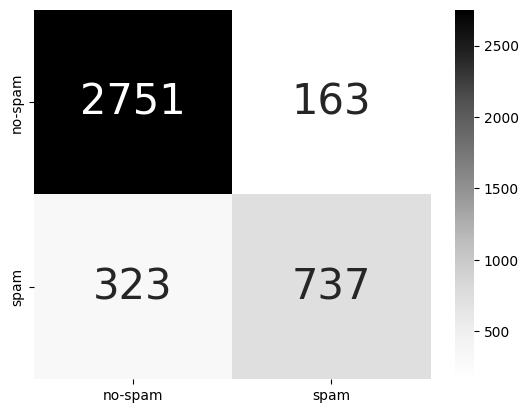

In [ ]:
show_predict_result(trainer, test_dataset, test_y, labels_task_1)